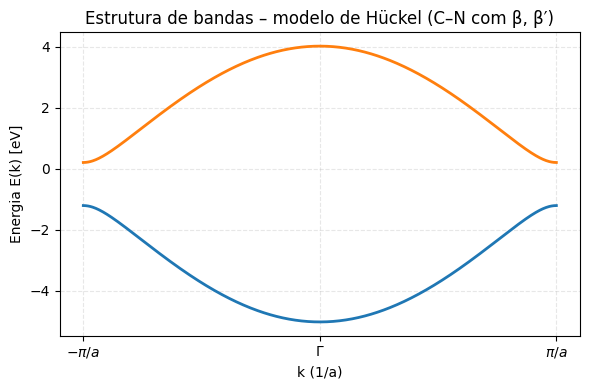

Populações e Ordens de Ligação (banda inferior ocupada)                    Quantidade     Valor
0                         n_C  0.771516
1                         n_N  1.231817
2                   n_C + n_N  2.003333
3  p_intra (C–N mesma célula)  0.780265
4       p_inter (C(n)–N(n+1))  0.457493
H(Gamma) - k=0           C         N
C  0.0+0.0j -4.5+0.0j
N -4.5-0.0j -1.0+0.0j
H(X) - k=π/a           C         N
C  0.0+0.0j -0.5-0.0j
N -0.5+0.0j -1.0+0.0j


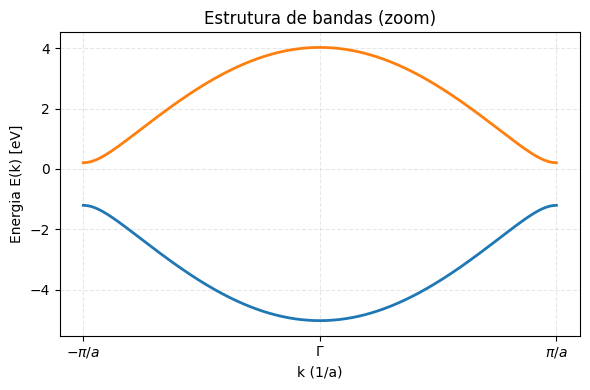

(                   Quantidade     Valor
 0                         n_C  0.771516
 1                         n_N  1.231817
 2                   n_C + n_N  2.003333
 3  p_intra (C–N mesma célula)  0.780265
 4       p_inter (C(n)–N(n+1))  0.457493,
 array([[ 0. +0.j, -4.5+0.j],
        [-4.5-0.j, -1. +0.j]]),
 array([[ 0. +0.0000000e+00j, -0.5-2.4492936e-16j],
        [-0.5+2.4492936e-16j, -1. +0.0000000e+00j]]),
 (np.float64(-5.027692569068709), np.float64(4.027692569068708)))

In [ ]:
# -*- coding: utf-8 -*-
"""
Hückel bands for a diatomic (C–N) 1D chain with periodic BCs.
Notebook version:
- mostra tabelas pandas
- plota bandas com matplotlib
- não salva arquivos
"""

import numpy as np
import matplotlib.pyplot as plt
from math import pi
import pandas as pd

# ========== Parâmetros ==========
alpha_C = 0.0    # eV
alpha_N = -1.0   # eV
beta    = -2.5   # eV
beta_p  = -2.0   # eV
a       = 1.0    # unidade de rede

# ========== Malha de k ==========
num_k = 601
k_vals = np.linspace(-pi/a, pi/a, num_k)
dk = k_vals[1] - k_vals[0]
pref = 2.0 / (2.0 * pi)  # spin / 2π

# ========== Hamiltoniano ==========
def H_k(k):
    off = beta + beta_p * np.exp(1j * k * a)
    return np.array([[alpha_C, off],
                     [np.conj(off), alpha_N]], dtype=complex)

H_Gamma = H_k(0.0)
H_X     = H_k(pi/a)

# ========== Diagonalização ==========
E = np.zeros((2, num_k))
vecs = np.zeros((2, 2, num_k), dtype=complex)

for i, kv in enumerate(k_vals):
    w, v = np.linalg.eigh(H_k(kv))
    order = np.argsort(w.real)
    w = w[order].real
    v = v[:, order]
    E[:, i] = w
    # fase consistente
    vl = v[:, 0]
    if np.abs(vl[0]) > 1e-14:
        phase = np.exp(-1j * np.angle(vl[0]))
        vl = vl * phase
    vecs[:, 0, i] = vl
    vecs[:, 1, i] = v[:, 1]

# ========== Populações e ordens ==========
c_lower = vecs[:, 0, :]
pop_C = pref * np.sum(np.abs(c_lower[0])**2) * dk
pop_N = pref * np.sum(np.abs(c_lower[1])**2) * dk
p_intra = pref * np.sum(np.real(np.conj(c_lower[0]) * c_lower[1])) * dk
p_inter = pref * np.sum(np.real(np.conj(c_lower[0]) * c_lower[1] * np.exp(1j * k_vals * a))) * dk

# Gap em X
wX, _ = np.linalg.eigh(H_X)
wX = np.sort(wX.real)
gap_X = wX[1] - wX[0]

# ========== Tabelas pandas ==========
summary = pd.DataFrame({
    "Grandeza": ["n(C)", "n(N)", "n(C)+n(N)",
                 "p_intra C–N (mesma célula)",
                 "p_inter N–C (n→n+1)",
                 "Gap em X [eV]"],
    "Valor": [pop_C, pop_N, pop_C + pop_N, p_intra, p_inter, gap_X]
}).round(4)

H_gamma_df = pd.DataFrame(H_Gamma.real, columns=["C", "N"], index=["C", "N"]).round(4)
H_X_df     = pd.DataFrame(H_X.real,     columns=["C", "N"], index=["C", "N"]).round(4)

print("=== H(Γ) – k=0 ===")
display(H_gamma_df)
print("=== H(X) – k=π/a ===")
display(H_X_df)
print("=== Populações, Ordens e Gap ===")
display(summary)

# ========== Gráficos ==========
plt.figure(figsize=(6,4))
plt.plot(k_vals, E[0], linewidth=2, label="E1(k) – banda inferior")
plt.plot(k_vals, E[1], linewidth=2, label="E2(k) – banda superior")
plt.xlabel("k (1/a)")
plt.ylabel("Energia [eV]")
plt.title("Estrutura de bandas – modelo de Hückel (C–N)")
plt.xticks([-pi, 0, pi], [r"$-\pi/a$", r"$\Gamma$", r"$\pi/a$"])
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.show()

# gráfico com zoom
plt.figure(figsize=(6,4))
plt.plot(k_vals, E[0], linewidth=2, label="E1(k)")
plt.plot(k_vals, E[1], linewidth=2, label="E2(k)")
plt.xlabel("k (1/a)")
plt.ylabel("Energia [eV]")
plt.title("Estrutura de bandas (zoom)")
plt.xticks([-pi, 0, pi], [r"$-\pi/a$", r"$\Gamma$", r"$\pi/a$"])
plt.ylim([np.min(E)-0.3, np.max(E)+0.3])
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()
